# Seismic velocity variations at station PATCX, Northern Chile

This notebook is a tutorial for the [yam](https://github.com/trichter/yam) package and calculates inter-station cross-correlations for the [IPOC](http://www.ipoc-network.org) network. The cross-correlations can be exported and used to extract surface wave dispersion curves for ambient noise tomography.

If you want to run this notebook locally, have a look at the repository [readme](https://github.com/trichter/notebooks). `yam` needs to be installed.

### Downloading data

First we import some classes, define the time window to investigate and download 1 month of IPOC data of the Z component with ObsPy's mass downloader.

In [1]:
from IPython.display import Image
from obspy import UTCDateTime as UTC

# this time-span should be larger to get a better estimate of the Green's function
starttime = UTC('2020-01-01')
endtime = UTC('2020-02-01')  

In [2]:
from obspy.clients.fdsn.mass_downloader import (
    GlobalDomain, Restrictions, MassDownloader)

domain = GlobalDomain()
restrictions = Restrictions(
    starttime=starttime, endtime=endtime,
    network='CX', location=None, channel_priorities=["HHZ"],
    chunklength_in_sec=86400, reject_channels_with_gaps=False,
    minimum_length=0.5)
mdl = MassDownloader(providers=['GFZ'])
mdl.download(domain, restrictions, 'day_files', 'stations')

### Configuration

yam is a python package and command line tool. Commands starting with `!` are executed on the shell command line. The configuration file is created in the following. We correlate in the frequency range 0.01 Hz to 0.5 Hz typical for surface waves.

In [3]:
conf = """{
"loglevel": 3,
"logfile": "yam_IPOC.log",
"io": {
        "inventory": "stations/*.xml",
        "data": "day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t.day:02d}*.mseed",
        "data_format": "MSEED",
        "corr": "corr.h5",
        "stack": "stack.h5",
        "stretch": "stretch.h5",
        "plot": "plots"
        },
"correlate": {
        "1": {  "startdate": "%s",
                "enddate": "%s",
                "length": 3600,
                "overlap": 1800,
                "discard": 0.9,
                "filter": [0.01, 0.5],
                "max_lag": 300,
                "normalization": ["1bit", "spectral_whitening"],
                "keep_correlations": false,
                "stack": "1d"
                }
        }
}""" % (str(starttime)[:10], str(endtime)[:10])

with open('conf.json', 'w') as f:
    f.write(conf)

### Preprocessing

`yam info` displays an overview over the project status. Station meta data is loaded successfully and data files can be found. After that we have a look at the data for the first day. Preprocessing is defined in the correlation configuration. One-bit normalization and spectral whitening is used. To check the preprocessing, original data and prepared data of the first day is plotted.

In [4]:
!yam info

Stations:
    CX.HMBCX CX.PATCX CX.PB01 CX.PB02 CX.PB03 CX.PB05 CX.PB06 CX.PB07 CX.PB08
    CX.PB09 CX.PB10 CX.PB11 CX.PB12 CX.PB14 CX.PB16 CX.PB18 CX.PB19 CX.PX06
    18 stations, 18 channels
Raw data (expression for day files):
    day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t
    .day:02d}*.mseed
    519 files found
Config ids:
    c Corr: 1
    s Stack: None
    t Stretch: None
Correlations (channel combinations, correlations calculated):
    None
Stacks:
    None
Stretching matrices:
    None


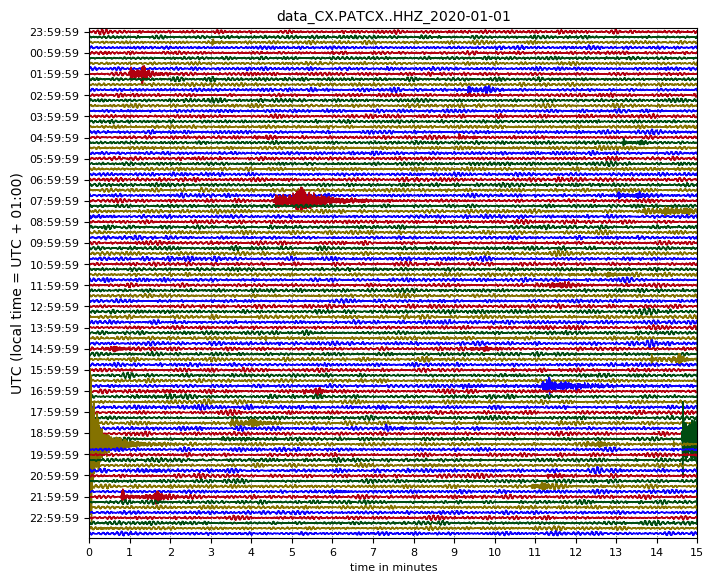

In [5]:
!yam plot data CX.PB01..HHZ 2020-01-01
Image("plots/data_CX.PATCX..HHZ_2020-01-01.png", width=600)

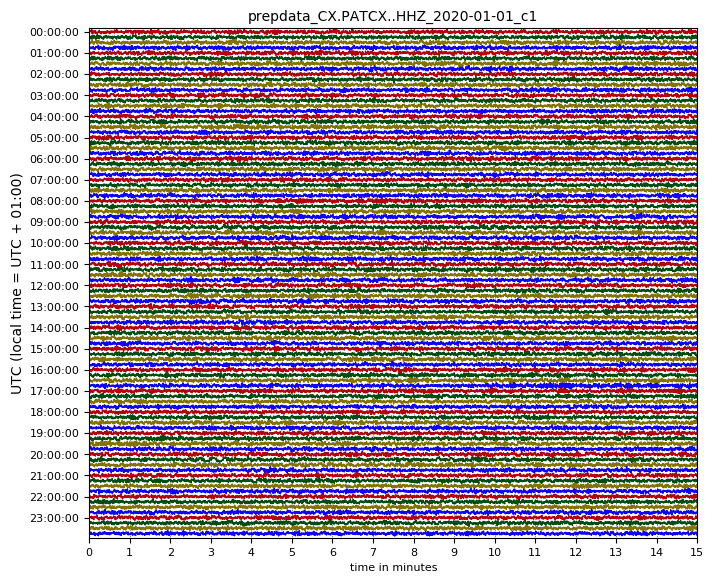

In [6]:
!yam plot prepdata CX.PATCX..HHZ 2020-01-01 1
Image("plots/prepdata_CX.PATCX..HHZ_2020-01-01_c1.png", width=600)

### Correlation, stacking, plotting and export

We start the correlation with the following command which uses the corresponding configuration `"1"` defined in the configuration file. Data is cross-correlated in 1-hour windows with 30 minutes overlap. The cross-correlation is stacked for each day and written to the HDF5 file. A parallel inner loop is used with 3 cores (otherwise the command might take too much RAM). In the next cell all correlations are stacked together for each SEED id separately. Finally the cross-correlations are plotted versus distance and exported to another waveform format for further processing.

In [7]:
!yam correlate 1 --parallel-inner-loop -n 3

In [8]:
!yam stack c1_s1d all  # stack the waveforms written in c1_s1d

In [9]:
!yam info

Stations:
    CX.HMBCX CX.PATCX CX.PB01 CX.PB02 CX.PB03 CX.PB05 CX.PB06 CX.PB07 CX.PB08
    CX.PB09 CX.PB10 CX.PB11 CX.PB12 CX.PB14 CX.PB16 CX.PB18 CX.PB19 CX.PX06
    18 stations, 18 channels
Raw data (expression for day files):
    day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t
    .day:02d}*.mseed
    519 files found
Config ids:
    c Corr: 1
    s Stack: None
    t Stretch: None
Correlations (channel combinations, correlations calculated):
    None
Stacks:
    c1_s1d: 171 combs, 4612 corrs
    c1_s1d_s: 171 combs, 171 corrs
Stretching matrices:
    None


`yam info` found two new groups in the resulting HDF5 files: `c1_s1d` resulted from correlation (`"c"`) with configuration `"1"` and subsequent stacking for each day (`"s1d"`). The 1-hour correlations are not kept as indicated in the corresponding configuration. `c1_s1d_s` resulted from stacking all correlations of each station pair together (configuration `"all"` in cell 8 and identifier `"s"` in the group identifier `"c1_s1d_s"`). Now, let's plot the stacked cross-correlations versus distance and export them to SAC format.

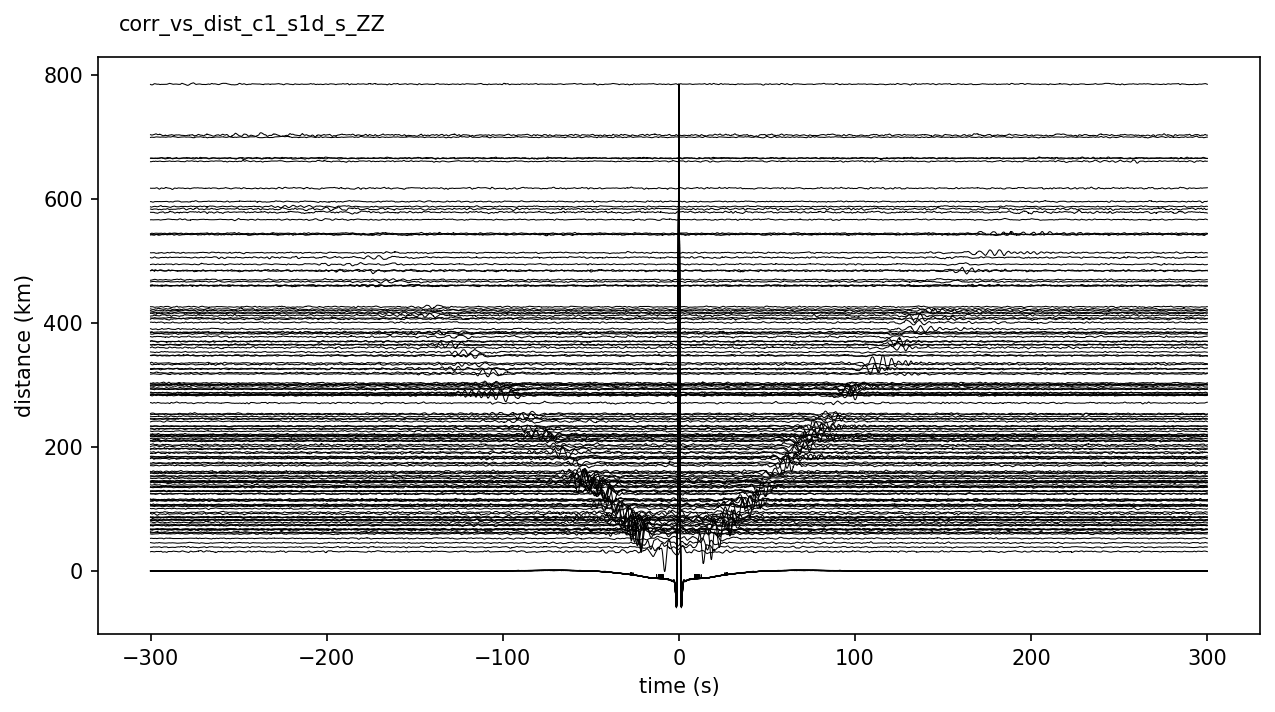

In [10]:
!yam plot c1_s1d_s --plottype vs_dist --plot-options '{"dpi": 150, "plot_kw":{"lw": 0.5}}'
Image('plots/corr_vs_dist_c1_s1d_s_ZZ.png')

In [11]:
!yam export c1_s1d_s cc.SAC  # export all 171 stacked ccs, one for each station combination
!ls *.SAC  # for linux, macos, use dir command on windwos

export 171 Trace(s) in Stream:

HMBCX.HHZ.HMBCX.HHZ | 2020-01-02T00:00:00.000000Z - 2020-01-02T00:10:00.000000Z | 100.0 Hz, 60001 samples
...
(169 other traces)
...
PX06.HHZ.PX06.HHZ | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:10:00.000000Z | 100.0 Hz, 60001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
cc01.SAC   cc115.SAC  cc138.SAC  cc160.SAC  cc29.SAC  cc54.SAC	cc79.SAC
cc02.SAC   cc116.SAC  cc139.SAC  cc161.SAC  cc30.SAC  cc55.SAC	cc80.SAC
cc03.SAC   cc117.SAC  cc13.SAC	 cc162.SAC  cc31.SAC  cc56.SAC	cc81.SAC
cc04.SAC   cc118.SAC  cc140.SAC  cc163.SAC  cc32.SAC  cc57.SAC	cc82.SAC
cc05.SAC   cc119.SAC  cc141.SAC  cc164.SAC  cc33.SAC  cc58.SAC	cc83.SAC
cc06.SAC   cc11.SAC   cc142.SAC  cc165.SAC  cc34.SAC  cc59.SAC	cc84.SAC
cc07.SAC   cc120.SAC  cc143.SAC  cc166.SAC  cc35.SAC  cc60.SAC	cc85.SAC
cc08.SAC   cc121.SAC  cc144.SAC  cc167.SAC  cc36.SAC  cc61.SAC	cc86.SAC
cc09.SAC   cc122.SAC  cc145.SAC  cc168.SAC  cc37.SAC  cc62.SAC	cc87.SAC
cc100.SAC  cc123.S